# Making imports


In [174]:
import math
import numpy as np
from matplotlib import pyplot as plt
import sys
import random
import scipy.optimize as opt
from scipy import stats
import torch
from tqdm import tqdm

random.seed(19680801)
np.random.seed(19680801)
torch.manual_seed(19680801)
torch.cuda.manual_seed(19680801)
torch.backends.cudnn.deterministic = True

# Task 3

# Class for storing coords

In [175]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y

# Defining optimization methods

In [196]:
def exhaustive_search(func, a, b, e = 0.001):
    optim_point = Point(math.inf, math.inf)
    
    n = int((b - a) / e)
    step = (b - a) / n
    
    for k in range(0, n):
        x_k = a + k * step
        y_k = func(x_k)
        
        if optim_point.y > y_k:
            optim_point = Point(x_k, y_k)
    
    iter_count = n
    f_calc_count = n

    return optim_point, iter_count, f_calc_count

## Generate random array

In [177]:
a = random.random()
b = random.random()

print(a, b)

0.18054507069218806 0.5676159350662024


In [179]:
x = np.linspace(0, 101, 101) / 100
sigma = np.random.normal(0, 1, 101)

y = a * x + b + sigma

# Some more functions for graphs

In [25]:
colors = ['b','g','r','c','m','y','k']

def plot_aprox_result(x, y, methods_and_coafs, aprox_func, aprox_method_name):
    num_of_plots = len(methods_and_coafs) + 1
    fig, ax = plt.subplots(num_of_plots, figsize=(6, 10))
    
    fig.suptitle(aprox_method_name)
    
    for idx, (method) in enumerate(methods_and_coafs) :
        ax[idx].scatter(x, y)
        coef = methods_and_coafs[method]
        
        color = colors[idx]
        ax[idx].plot(x, aprox_func(x, coef[0], coef[1] ), label=method, color=color)
        ax[idx].set(xlabel='x', ylabel='y')
    
        ax[idx].legend()
        ax[idx].grid()
    
    num_of_plots -= 1
    ax[num_of_plots].scatter(x, y)
    ax[num_of_plots].set(xlabel='x', ylabel='y')
    
    for idx, (method) in enumerate(methods_and_coafs):
       
        coef = methods_and_coafs[method]
        print(coef)
        
        color = colors[idx]
        ax[num_of_plots].plot(x, aprox_func(x, coef[0], coef[1] ), label=method, color=color)
    
        ax[num_of_plots].legend()
        ax[num_of_plots].grid()
        
    plt.show()

In [311]:
def make_table_2d(table_data,
               row_headers = ['exhaustive_search_2d','Gauss','Nelder-Mead'],
               column_headers = ['iter_count','f_calc_count', 'squared error']):
    
    for data in table_data:
        data[2] = round(data[2], 2)
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=table_data,
        rowLabels=row_headers,
        colLabels=column_headers,
        loc='center',
        cellLoc='center')

    plt.show()

# Defining loss functions for regression

In [232]:
def linear(x, a, b): 
    return a * x + b

def rational(x, a, b):
    return a / (1 + b * x)

#Spesial version for loss to use in scipy optimisation
def loss_linear(z, *params): 
    x, y = params
    a, b = z
    return np.sum((linear(x, a, b) - y)**2)

#Functional version for loss to calc precision
def f_loss_linear(x, y, a, b): 
    return np.sum((linear(x, a, b) - y)**2)

#Spesial version for loss to use in scipy optimisation
def loss_rational(z, *params): 
    x, y = params
    a, b = z
    return np.sum((rational(x, a, b) - y)**2)

#Functional version for loss to calc precision
def f_loss_rational(x, y, a, b): 
    return np.sum((rational(x, a, b) - y)**2)


#Spesial version for loss to use in LMA method
def loss_linear_lma(z, *params): 
    x, y = params
    a, b = z
    return (linear(x, a, b) - y)**2

#Spesial version for loss to use in LMA method
def loss_rational_lma(z, *params): 
    x, y = params
    a, b = z
    return (rational(x, a, b) - y)**2

# Calculating regression coefs by different methods

# Brute force method linear

In [233]:
brute_force = opt.brute(loss_linear, ([0,1],[0,1]), args=(x,y),  Ns = 1000, full_output=True)

In [254]:
brute_force_coafs = brute_force[0]
grid_size_x, grid_size_y = len(brute_force[2][0]), len(brute_force[2][0])
brute_froce_iter_count =  grid_size_x * grid_size_y
brute_force_f_calc_count = brute_froce_iter_count
brute_force_precision = f_loss_linear(x, y, brute_force_coafs[0], brute_force_coafs[1])

In [259]:
brute_force_result = [brute_froce_iter_count, brute_force_f_calc_count, brute_force_precision]

# Brute force method rational

In [256]:
brute_force_rational = opt.brute(loss_rational, ([0,1],[0,1]), args=(x,y),  Ns = 1000, full_output=True)

In [260]:
brute_force_coafs_rational = brute_force_rational[0]
grid_size_x, grid_size_y = len(brute_force_rational[2][0]), len(brute_force_rational[2][0])
brute_froce_iter_count_rational =  grid_size_x * grid_size_y
brute_force_f_calc_count_rational = brute_froce_iter_count_rational
brute_force_precision_rational = f_loss_rational(x, y, brute_force_coafs_rational[0], brute_force_coafs_rational[1])

In [261]:
brute_force_result_rational = [brute_froce_iter_count_rational,
                               brute_force_f_calc_count_rational,
                               brute_force_precision_rational]

# Coordinate descent method

In [262]:
def get_loss_func(fix_coord, loss_type, coefs):
    if loss_type == 'rational':
        func = rational
    if loss_type == 'linear':
        func = linear

    if fix_coord == 'a':
        return lambda a: np.sum((func(x, a, coefs[1]) - y)**2)
    if fix_coord == 'b':
        return lambda b: np.sum((func(x, coefs[0], b) - y)**2)

def coordinate_descent(params, limits, loss_type, e=0.00001):
    dims = len(params)
    coefs = np.random.randn(dims) * 100
    min_loss_value = Point(float('inf'), float('inf'))
    iter_sum = 0
    func_calc_sum = 0
    
    while True:
        L = get_loss_func('a', loss_type, coefs)
        optim_point, iter_count, f_calc_count = exhaustive_search(L, *limits[0])
        coefs[0] = optim_point.x
        
        iter_sum += iter_count  
        func_calc_sum += f_calc_count
        
        L = get_loss_func('b', loss_type, coefs)
        optim_point, iter_count, f_calc_count = exhaustive_search(L, *limits[1])
        coefs[1] = optim_point.x
        
        iter_sum += iter_count  
        func_calc_sum += f_calc_count

        if abs(min_loss_value.x - optim_point.x) <= e and abs(min_loss_value.y - optim_point.y) <= e:
            break
        else:
            min_loss_value = optim_point

    return coefs, iter_sum, func_calc_sum
 

## Coordinate descent linear 

In [263]:
coord_descent_coefs,\
coord_descent_iter_sum,\
coord_descent_func_calc_sum = coordinate_descent((x, y), ((-1,1),(-1,1)),loss_type='linear')
coord_descent_precision = f_loss_linear(x, y, coord_descent_coefs[0], coord_descent_coefs[1])

coordinate_descent_result = [coord_descent_iter_sum, coord_descent_func_calc_sum, coord_descent_precision]

In [264]:
coordinate_descent_result

[88000, 88000, 90.92146382585027]

## Coordinate descent rational 

In [265]:
coord_descent_coefs_rational,\
coord_descent_iter_sum_rational,\
coord_descent_func_calc_sum_rational = coordinate_descent((x, y), ((-1,1),(-1,1)), loss_type='rational')
coord_descent_precision_rational = f_loss_rational(x, y, coord_descent_coefs[0], coord_descent_coefs[1]) 

coordinate_descent_result_rational = [coord_descent_iter_sum, coord_descent_func_calc_sum, coord_descent_precision]

# Nelder-Mead linear

In [266]:
initial_guess = [0, 0]
nelder_mead = opt.minimize(loss_linear, initial_guess, args=(x,y), method='Nelder-Mead', tol = 0.001)

In [267]:
nelder_mead_result = [nelder_mead['nit'], nelder_mead['nfev'], nelder_mead['fun']]

# Nelder-Mead rational

In [268]:
initial_guess = [0, 0]
nelder_mead_rational = opt.minimize(loss_rational, initial_guess, args=(x,y), method='Nelder-Mead', tol = 0.001)

In [269]:
nelder_mead_result_rational = [nelder_mead_rational['nit'], nelder_mead_rational['nfev'], nelder_mead_rational['fun']]

# Visualising result of calculationg coefs

[-0.10617496  0.69415804]
[-0.104  0.693]
[-0.10585323  0.69401721]


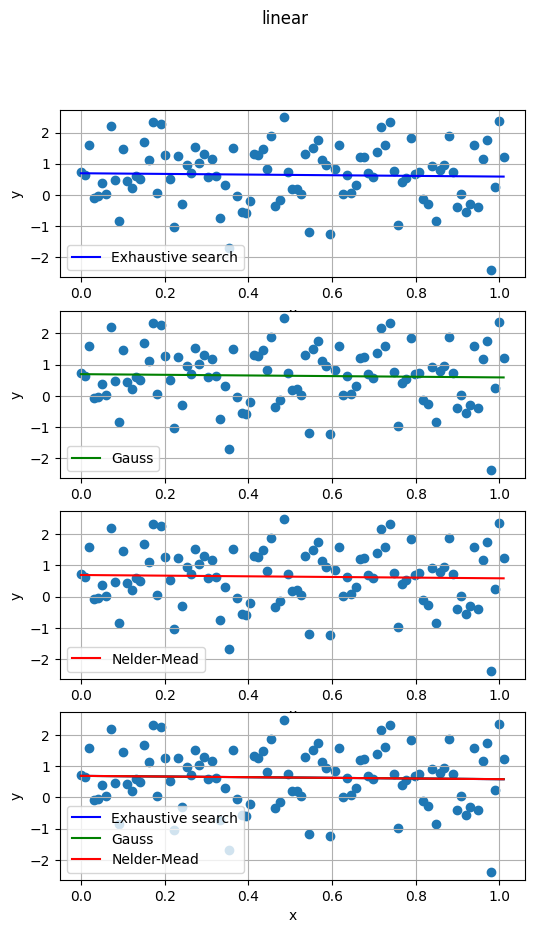

In [270]:
methods_and_coafs = {
    'Exhaustive search': brute_force_coafs,
    'Gauss': coord_descent_coefs,
    'Nelder-Mead': nelder_mead['x'],
}

plot_aprox_result(x, y, methods_and_coafs,linear, 'linear')

[0.6941576  0.17018944]
[0.696 0.175]
[0.69429687 0.17040497]


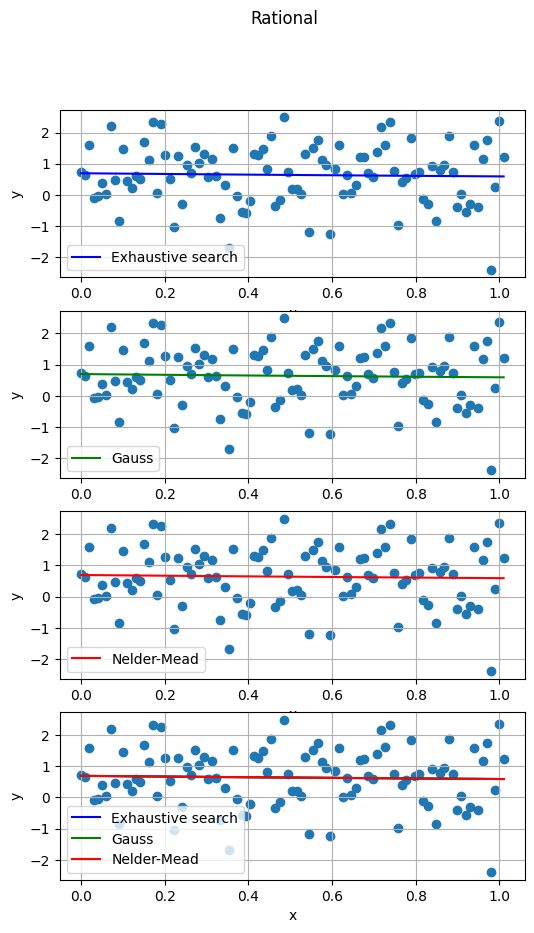

In [273]:
methods_and_coafs = {
    'Exhaustive search': brute_force_coafs_rational,
    'Gauss': coord_descent_coefs_rational,
    'Nelder-Mead': nelder_mead_rational['x'],
}

plot_aprox_result(x, y, methods_and_coafs,rational, 'Rational')

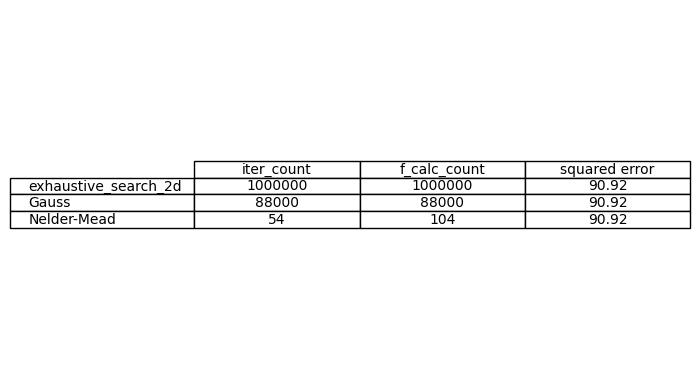

In [282]:
make_table_2d([brute_force_result,coordinate_descent_result,nelder_mead_result])

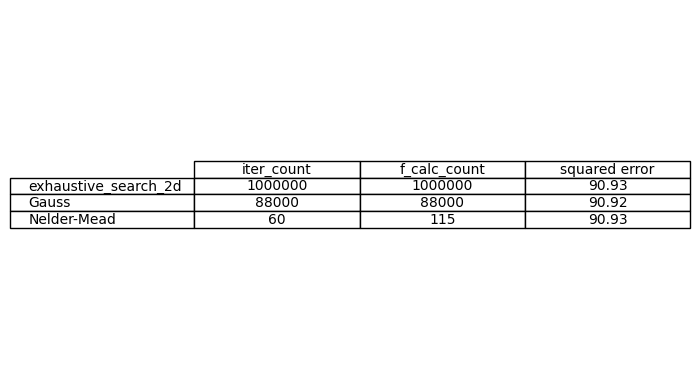

In [283]:
make_table_2d([brute_force_result_rational,coordinate_descent_result_rational,nelder_mead_result_rational])

# Gradient descent linear

In [329]:
class RegressionModel(torch.nn.Module):
    def __init__(self, reg_func):

        super().__init__()
        self.reg_func = reg_func
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        return self.reg_func(x, self.a, self.b) #self.a / (1 +  self.b * x)

    def string(self):
        return f'y = {self.a.item()} / (1 + {self.b.item()} * x)'

    def get_coefs(self):
        return self.a.item(), self.b.item()
    

def SGD(x, y, reg_func, lr=0.001, epoch_count=2000, show_loss_graph=True):
    model = RegressionModel(reg_func)

    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    loss_list = []

    X = torch.from_numpy(x)
    Y = torch.from_numpy(y)

    y_min = float('inf')
    y_pred = float('inf')
    epoch_count = 0

    while True:
        epoch_count += 1
        
        y_pred = model(X)
        
        loss = criterion(y_pred, Y)
        loss_list.append(loss.item())

        
        if abs(y_min - loss.item()) < 0.001 and epoch_count % 10 == 0:
            break
        else:
            y_min = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if show_loss_graph:
        plt.plot(loss_list, 'r')
        plt.tight_layout()
        plt.grid()
        plt.xlabel("Epochs/Iterations")
        plt.ylabel("Loss")
        plt.show()

    iter_num = epoch_count
    func_calc_num = epoch_count
    precision = loss_list[len(loss_list)-1]
    return *model.get_coefs(), iter_num, func_calc_num, precision

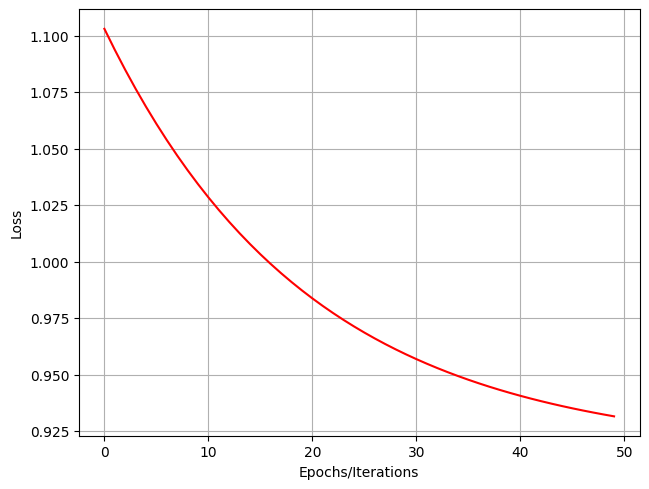

In [330]:
w, b, iter_num, func_calc_num, precision = SGD(x, y, linear, epoch_count=400, lr=0.01)

In [331]:
SGD_result_linear = [iter_num, func_calc_num, precision]

# Gradient descent rational

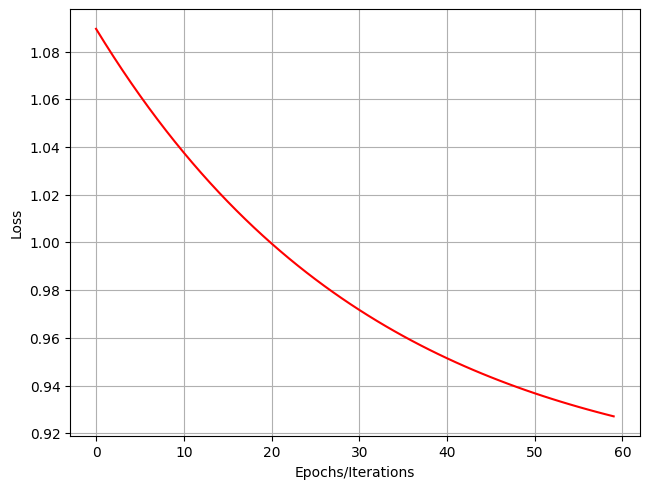

In [333]:
w_rational, b_rational, iter_num_rational, func_calc_num_rational, precision_rational = SGD(x, y, rational, epoch_count=400, lr=0.01)

In [334]:
SGD_result_rational = [iter_num_rational, func_calc_num_rational, precision_rational]

# Conjugate gradient linear

In [291]:
initial_guess = [0, 0]
conjugate_linear = opt.minimize(loss_linear, initial_guess, args=(x,y), method='CG', tol = 0.001)

In [292]:
conjugate_linear

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 90.92142091635121
       x: [-1.062e-01  6.942e-01]
     nit: 2
     jac: [ 0.000e+00  9.537e-07]
    nfev: 15
    njev: 5

In [293]:
conjugate_result_linear = [conjugate_linear['nit'], conjugate_linear['nfev'], conjugate_linear['fun']]

# Conjugate gradient rational

In [294]:
initial_guess = [0, 0]
conjugate_rational = opt.minimize(loss_rational, initial_guess, args=(x,y), method='CG', tol = 0.001)

In [295]:
conjugate_result_rational = [conjugate_rational['nit'], conjugate_rational['nfev'], conjugate_rational['fun']]

# Newton linear

In [296]:
initial_guess = [0, 0]
newton_linear = opt.minimize(loss_linear, initial_guess, args=(x,y), method='BFGS', tol=0.001)

In [297]:
newton_result_linear = [newton_linear['nit'], newton_linear['nfev'], newton_linear['fun']]

# Newton rational

In [298]:
initial_guess = [0, 0]
newton_rational = opt.minimize(loss_rational, initial_guess, args=(x,y), method='BFGS')

In [299]:
newton_result_rational = [newton_rational['nit'], newton_rational['nfev'], newton_rational['fun']]

# Levenberg-Marquardt linear

In [300]:
initial_guess = [0, 0]
lma_linear = opt.least_squares(loss_linear_lma, initial_guess, args=(x,y), method='lm')

In [301]:
lma_linear

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 9.104e-05  7.286e-03 ...  4.051e+00  7.786e-01]
           x: [-3.869e-01  7.324e-01]
        cost: 119.91499607446721
         jac: [[ 0.000e+00  1.908e-02]
               [ 1.724e-03  1.707e-01]
               ...
               [-4.025e+00 -4.026e+00]
               [-1.782e+00 -1.765e+00]]
        grad: [ 8.831e-03  1.442e-02]
  optimality: 0.014416263524058389
 active_mask: [0 0]
        nfev: 40
        njev: None

In [314]:
lma_result_linear = [len(lma_linear['fun']), lma_linear['nfev'], lma_linear['cost']]

# Levenberg-Marquardt rational

In [303]:
initial_guess = [0, 0]
lma_rational = opt.least_squares(loss_rational_lma, initial_guess, args=(x,y), method='lm')

In [315]:
lma_result_rational = [len(lma_rational['fun']), lma_rational['nfev'], lma_rational['cost']]

# Plotting graphs for second order methods

[0.3816547989845276, 0.18054507069218806]
[-0.1061994   0.69418446]
[-0.10619931  0.69418441]
[-0.38694193  0.73237821]


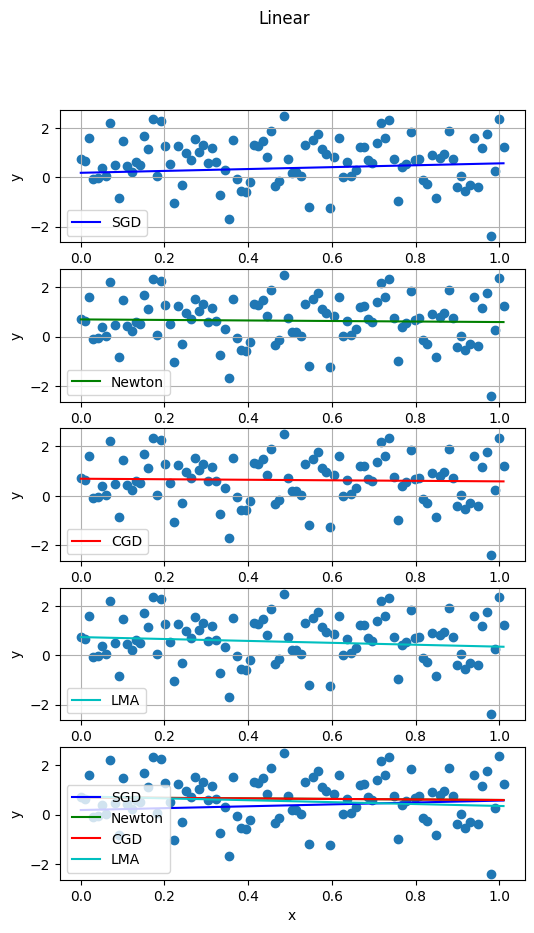

In [335]:
methods_and_coafs = {
    'SGD': [w, a],
    'Newton': newton_linear['x'],
    'CGD': conjugate_linear['x'],
    'LMA': lma_linear['x'],
}

plot_aprox_result(x, y, methods_and_coafs, linear, 'Linear')

[-0.1574544459581375, 0.18054507069218806]
[-0.1061994   0.69418446]
[-0.10619931  0.69418441]
[-0.38694193  0.73237821]


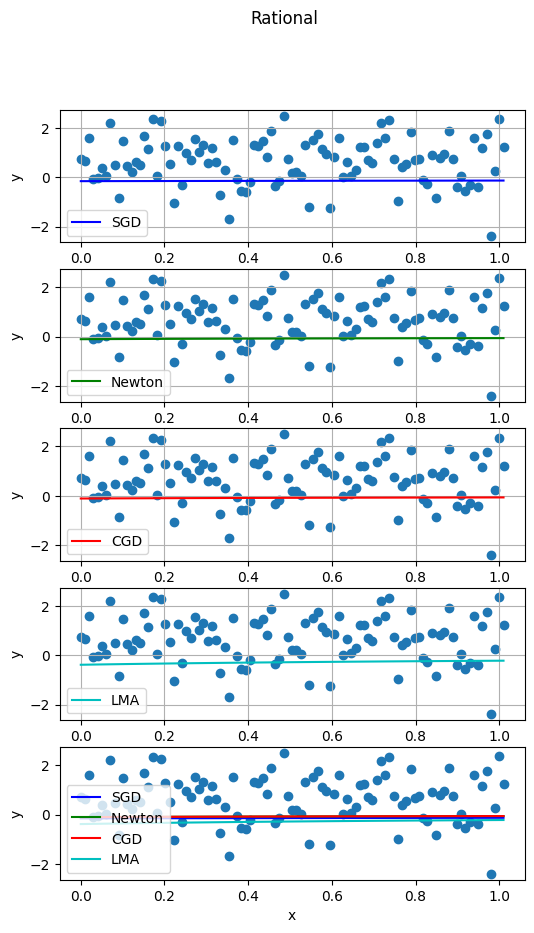

In [309]:
methods_and_coafs_rational = {
    'SGD': [w_rational, b_rational],
    'Newton': newton_rational['x'],
    'CGD': conjugate_rational['x'],
    'LMA': lma_rational['x'],
}

plot_aprox_result(x, y, methods_and_coafs, rational, 'Rational')

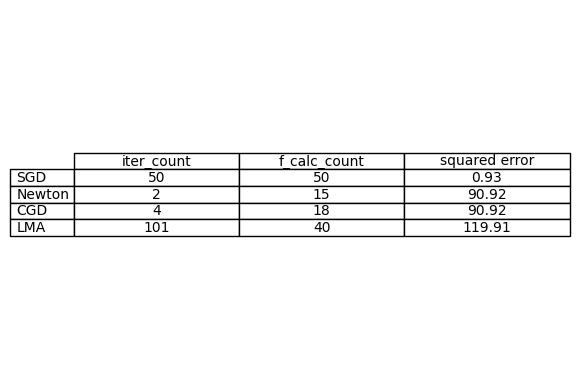

In [336]:
make_table_2d([SGD_result_linear, conjugate_result_linear, newton_result_linear, lma_result_linear],
               row_headers = list(methods_and_coafs.keys()),
               column_headers = ['iter_count','f_calc_count', 'squared error'])

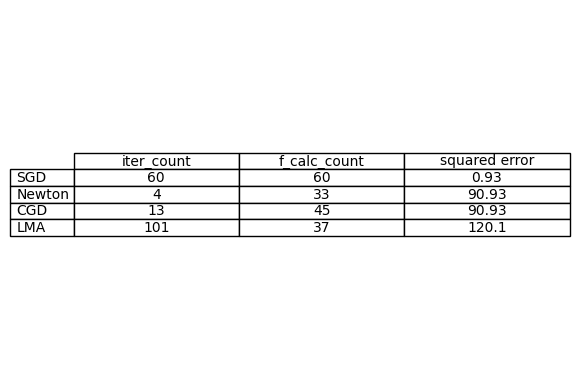

In [337]:
make_table_2d([SGD_result_rational, conjugate_result_rational, newton_result_rational, lma_result_rational],
               row_headers = list(methods_and_coafs_rational.keys()),
               column_headers = ['iter_count','f_calc_count', 'squared error'])